# Forcasting Windpower Supply

In [80]:

import pandas as pd
from tqdm import tqdm
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [81]:
dtype_dict = {
    'v10': float,
    'u10': float,
}

df_weather = pd.read_csv('./datasets/Weather_Data_Germany.csv', dtype=dtype_dict)
df_weather.head()

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394
2,5.8,52.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,478.410160,103077.450,862.93030,0.999504,4.976940,1.899902,280.48530,0.0,0.0,0.0,0.0,0.439765,8.450895,2.586425
3,5.8,51.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,237.821290,103310.510,619.56150,0.999992,3.810944,1.201527,280.26593,0.0,0.0,0.0,0.0,0.645616,6.853557,1.614200
4,5.8,50.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,4681.780000,103456.680,385.46838,0.999992,3.689941,-0.424220,277.94235,0.0,0.0,0.0,0.0,0.361133,6.055728,-0.896704


In [82]:
dtype_dict = {
    'Wind Offshore [MW]': float,
    'Wind Onshore [MW]': float,
}

df_supply = pd.read_csv('./datasets/Realised_Supply_Germany.csv', sep=';',decimal=',',thousands='.' )
df_supply.head()

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Photovoltaic [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,1199.00,401.00,794.25,4839.25,0.0,31.5,2250.50,1733.00,836.25,850.50,87.50,431.75
1,01.01.19 00:15,01.01.19 00:30,1203.00,394.75,793.50,5030.75,0.0,31.5,2263.25,1587.75,729.50,821.50,99.25,429.75
2,01.01.19 00:30,01.01.19 00:45,1204.50,381.25,791.75,5213.50,0.0,31.5,2246.00,1555.25,648.50,804.75,44.00,431.25
3,01.01.19 00:45,01.01.19 01:00,1208.75,381.00,754.50,5308.25,0.0,31.5,2241.75,1459.00,597.50,796.50,41.00,431.50
4,01.01.19 01:00,01.01.19 01:15,1204.50,388.25,715.50,5398.50,0.0,31.5,2224.50,1367.75,610.50,765.50,21.00,429.25


In [83]:
import math
relevant_columns = ['time','u10','v10', 'u100', 'v100']
df_wind = df_weather[relevant_columns].copy()


df_wind['WS10'] = np.sqrt(df_wind['u10']**2 + df_wind['v10']**2)
df_wind['WS100'] = np.sqrt(df_wind['u100']**2 + df_wind['v100']**2)

 # Make a copy to avoid the SettingWithCopyWarning
df_wind['time'] = pd.to_datetime(df_wind['time'], format='%Y-%m-%d %H:%M:%S')
#df_wind['time'] = df_wind['time'].dt.tz_localize('Europe/Berlin', ambiguous='NaT', nonexistent='NaT')
df_wind['year'] = df_wind['time'].dt.year
df_wind['month'] = df_wind['time'].dt.month
#df_sun['day'] = df_sun['time'].dt.day
df_wind['hour'] = df_wind['time'].dt.hour

df_wind['hour_sin'] = np.sin(2 * np.pi * df_wind['hour'] / 24)
df_wind['hour_cos'] = np.cos(2 * np.pi * df_wind['hour'] / 24)
df_wind['month_sin'] = np.sin(2 * np.pi * df_wind['month'] / 12)
df_wind['month_cos'] = np.cos(2 * np.pi * df_wind['month'] / 12)
df_wind.drop(columns=['month', 'hour', 'u10', 'v10', 'u100', 'v100'], inplace=True)
df_wind.head()
#df_wind.to_csv("here.csv", index=False)

,time,WS10,WS100,year,hour_sin,hour_cos,month_sin,month_cos
0,2019-01-01,12.139981,15.980293,2019,0.0,1.0,0.5,0.866025
1,2019-01-01,6.860216,11.087953,2019,0.0,1.0,0.5,0.866025
2,2019-01-01,5.327247,8.837829,2019,0.0,1.0,0.5,0.866025
3,2019-01-01,3.995868,7.041085,2019,0.0,1.0,0.5,0.866025
4,2019-01-01,3.714246,6.121758,2019,0.0,1.0,0.5,0.866025


In [84]:
relevant_columns = ['Date from','Wind Offshore [MW]','Wind Onshore [MW]']
df_wind_supply = df_supply[relevant_columns].copy()
df_wind_supply['Wind Total [MW]'] = df_wind_supply['Wind Offshore [MW]']+df_wind_supply['Wind Onshore [MW]']


df_wind_supply['time'] = pd.to_datetime(df_wind_supply['Date from'], format='%d.%m.%y %H:%M')
#df_wind_supply['time'] = df_sun_supply['time'].dt.tz_localize('Europe/Berlin', ambiguous='NaT', nonexistent='NaT')
df_wind_supply['year'] = df_wind_supply['time'].dt.year
df_wind_supply['month'] =df_wind_supply['time'].dt.month
df_wind_supply['day'] = df_wind_supply['time'].dt.day
df_wind_supply['hour'] = df_wind_supply['time'].dt.hour
df_wind_supply.drop(columns=['Date from'], inplace=True)
df_wind_supply.head()

,Wind Offshore [MW],Wind Onshore [MW],Wind Total [MW],time,year,month,day,hour
0,794.25,4839.25,5633.50,2019-01-01 00:00:00,2019,1,1,0
1,793.50,5030.75,5824.25,2019-01-01 00:15:00,2019,1,1,0
2,791.75,5213.50,6005.25,2019-01-01 00:30:00,2019,1,1,0
3,754.50,5308.25,6062.75,2019-01-01 00:45:00,2019,1,1,0
4,715.50,5398.50,6114.00,2019-01-01 01:00:00,2019,1,1,1


In [85]:
def average_rows(group):
    first_timestamp = group['time'].iloc[0]
    averaged_data = group.drop(columns=['time']).mean()
    averaged_data['time'] = first_timestamp
    mw_data_points = group.drop(columns=['time']).values.tolist()
    return averaged_data    
#df_wind_supply['Photovoltaic [MW]'] = df_wind_supply['Photovoltaic [MW]'].str.replace('.', '').str.replace(',', '.').astype(float)


print("Length of groupings:", len(df_wind_supply.index // 4))
wind_supply_df = df_wind_supply.groupby(df_wind_supply.index // 4).apply(average_rows).reset_index(drop=True)

#TODO


df_wind_supply_dropped = wind_supply_df.drop(columns=['year', 'month', 'day', 'hour', 'Wind Onshore [MW]','Wind Offshore [MW]'])

df_merged = pd.merge(df_wind, df_wind_supply_dropped, on='time')
#df_merged.drop(columns=["Wind Total [MW]"], inplace=True)
#pd.options.display.max_columns = None  # Show all columns
#pd.options.display.max_rows = None  # Show all rows
pd.options.display.width = None  # Do not wrap columns
print(len(df_merged))
print(len(wind_supply_df))
df_merged.head()

Length of groupings: 140256
2805120
35064


,time,WS10,WS100,year,hour_sin,hour_cos,month_sin,month_cos,Wind Total [MW]
0,2019-01-01,12.139981,15.980293,2019,0.0,1.0,0.5,0.866025,5881.4375
1,2019-01-01,6.860216,11.087953,2019,0.0,1.0,0.5,0.866025,5881.4375
2,2019-01-01,5.327247,8.837829,2019,0.0,1.0,0.5,0.866025,5881.4375
3,2019-01-01,3.995868,7.041085,2019,0.0,1.0,0.5,0.866025,5881.4375
4,2019-01-01,3.714246,6.121758,2019,0.0,1.0,0.5,0.866025,5881.4375


In [86]:
import pickle
import os
train_pickle_file = 'serialized_data/df_wind_list_train.pkl'
test_pickle_file = 'serialized_data/df_wind_list_test.pkl'

if 1 == 5:
    with open(train_pickle_file, 'rb') as f:
        df_wind_list_train = pickle.load(f)
    with open(test_pickle_file, 'rb') as f:
        df_wind_list_test = pickle.load(f)
else: 
    df_wind_list_train = []
    df_wind_list_test = []

    values = []
    row_counter = 0

    for index, row in tqdm(df_merged.iterrows(), total=len(df_merged)):
        if row_counter == 0:
            for value in row.drop(["time","year"]).values:
                values.append(value)
        else:
            values.append(row["WS10"])
            values.append(row["WS100"])
           

        row_counter += 1

        if row_counter == 80:
            if row["year"] in [2020, 2019, 2021]:
                df_wind_list_train.append(values.copy())
            elif row["year"] == 2022:
                df_wind_list_test.append(values.copy())
            else:
                print("Year not in expected range.")

            
            values = []
            row_counter = 0
    
        
       
with open('df_wind_list_train.txt', 'w') as f:
    for item in df_wind_list_train:
        f.write("%s\n" % item)
        
print(len(df_wind_list_train))
print(len(df_wind_list_test))
print(len(df_wind_list_train[0]))
#df_merged.head(100)       

100%|██████████| 2805120/2805120 [00:57<00:00, 48759.13it/s]


26304
8760
165


In [87]:
df_wind_supply_list_train = []
df_wind_supply_list_test = []
nna_count = 0
print(len(wind_supply_df))
for index, row in tqdm(wind_supply_df.iterrows(), total=len(wind_supply_df)):
    
    if float(row["year"]) in [2020.0, 2019.0,2021.0]:
        df_wind_supply_list_train.append(row['Wind Total [MW]'])
    elif float(row["year"]) in [2022.0]:
        df_wind_supply_list_test.append(row['Wind Total [MW]'])
    else:
        print("Row with unexpected year:", row["year"])

print(len(df_wind_supply_list_train))
print(len(df_wind_supply_list_test))

35064


100%|██████████| 35064/35064 [00:00<00:00, 47327.96it/s]

26304
8760


In [88]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

class CustomSequential(tf.keras.Sequential):
    def predict_24(self, X):
        pass
    
def myrmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    


In [89]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

import numpy as np




X_train_scaled = np.array(df_wind_list_train[:-1])

y_train = np.array(df_wind_supply_list_train[1:])

X_test_scaled= np.array(df_wind_list_test[:-1])

y_test = np.array(df_wind_supply_list_test[1:])

model = CustomSequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  
    layers.Dense(512, activation='relu'), 
    layers.Dense(256, activation='relu'), 
    layers.Dense(128, activation='relu'),  
    layers.Dense(64, activation='relu'),   
    layers.Dense(32, activation='relu'),   
    layers.Dense(1)  
])
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Mean squared error for regression
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]) 

history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=32)

test_loss, test_rmse = model.evaluate(X_test_scaled, y_test) 

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Mean Squared Error: {test_rmse:.4f}")




Epoch 1/40
822/822 [==============================] - 2s 1ms/step - loss: 368219.7500 - rmse: 606.8112
Epoch 2/40
822/822 [==============================] - 1s 1ms/step - loss: 69270.0156 - rmse: 263.1920
Epoch 3/40
822/822 [==============================] - 1s 1ms/step - loss: 69732.5234 - rmse: 264.0692
Epoch 4/40
822/822 [==============================] - 1s 1ms/step - loss: 70233.0469 - rmse: 265.0152
Epoch 5/40
822/822 [==============================] - 1s 1ms/step - loss: 67341.1250 - rmse: 259.5017
Epoch 6/40
822/822 [==============================] - 1s 1ms/step - loss: 68460.8984 - rmse: 261.6503
Epoch 7/40
822/822 [==============================] - 1s 1ms/step - loss: 70247.9375 - rmse: 265.0433
Epoch 8/40
822/822 [==============================] - 1s 1ms/step - loss: 65680.1484 - rmse: 256.2814
Epoch 9/40
822/822 [==============================] - 1s 1ms/step - loss: 64577.6562 - rmse: 254.1213
Epoch 10/40
822/822 [==============================] - 1s 1ms/step - loss: 64057.

Grid search for best parameters, commented out because it takes too long and makes "run all" infeasable. In general, it is recommended to convert this Notbook to a .py file and run this part there.

In [90]:
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Initialize lists to store RMSE values for plotting
rmse_values = []

# Define epoch and batch size options
epochs_options = list(range(1, 51))
batch_size_options = [32, 64,128, 256]

# Define different architectures to test
architectures = [
    [512, 256, 128, 64, 32],  # Original architecture
    [128, 64, 32, 16],       # Slightly smaller
    [512, 256, 128, 64],      # Remove one layer
    [256, 128, 32, 16]
]

best_test_rmse = np.inf
best_epoch = None
best_batch_size = None
best_architecture = None
best_model = None

# Open the file once before the loop
with open('grid_search_results.txt', 'w') as f:
    f.write("Architecture\tEpochs\tBatch Size\tTest RMSE\n")  # Write the header

# Perform grid search
for architecture in architectures:
    for batch_size in batch_size_options:
        rmse_values = []
        for epochs in epochs_options:
            print(f"Training model with architecture {architecture}, {epochs} epochs and batch size of {batch_size}...")
            
            # Build the model for the current architecture
            model = keras.Sequential()
            model.add(layers.Input(shape=(X_train_scaled.shape[1],)))  # Input layer
            for units in architecture:
                model.add(layers.Dense(units, activation='relu'))  # Add each layer in the architecture
            model.add(layers.Dense(1))  # Output layer

            model.compile(optimizer='adam',
                          loss='mean_squared_error',  # Mean squared error for regression
                          metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate on test data
            test_loss, test_rmse = model.evaluate(X_test_scaled, y_test, verbose=0)

            y_pred_hourly = model.predict(X_test_scaled)
            y_test_hourly = y_test
            rmse = np.sqrt(mean_squared_error(y_test_hourly, y_pred_hourly))
            rmse_values.append(rmse)  # Store RMSE for this epoch

            # Write the result to the file after each iteration
            with open('grid_search_results.txt', 'a') as f:
                f.write(f"{architecture}\t{epochs}\t{batch_size}\t{test_rmse:.4f}\n")

            # Check if this is the best model
            if rmse < best_test_rmse:
                best_test_rmse = rmse
                best_epoch = epochs
                best_batch_size = batch_size
                best_architecture = architecture
                best_model = model
                print(f"Update, new Best Test RMSE: {best_test_rmse:.4f} with architecture={best_architecture}, epochs={best_epoch} and batch_size={best_batch_size}")

        # Plot RMSE values by epochs and save the plot
        plt.plot(epochs_options, rmse_values, marker='o')
        #plt.title(f'Test RMSE by Epochs with batch size {batch_size} and architecture {architecture}')
        plt.xlabel('Epochs')
        plt.ylabel('Test RMSE')
        plt.grid(True)
        
        # Save the plot with a descriptive filename
        plot_filename = f"rmse_epochs_batchsize_{batch_size}_architecture_{architecture}.png"
        plt.savefig(plot_filename)
        plt.close()  # Close the plot to free up memory

print(f"Best Test RMSE: {best_test_rmse:.4f} with architecture={best_architecture}, epochs={best_epoch}, and batch_size={best_batch_size}")
'''


'\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import mean_squared_error\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\n\n# Initialize lists to store RMSE values for plotting\nrmse_values = []\n\n# Define epoch and batch size options\nepochs_options = list(range(1, 51))\nbatch_size_options = [32, 64,128, 256]\n\n# Define different architectures to test\narchitectures = [\n    [512, 256, 128, 64, 32],  # Original architecture\n    [128, 64, 32, 16],       # Slightly smaller\n    [512, 256, 128, 64],      # Remove one layer\n    [256, 128, 32, 16]\n]\n\nbest_test_rmse = np.inf\nbest_epoch = None\nbest_batch_size = None\nbest_architecture = None\nbest_model = None\n\n# Open the file once before the loop\nwith open(\'grid_search_results.txt\', \'w\') as f:\n    f.write("Architecture\tEpochs\tBatch Size\tTest RMSE\n")  # Write the header\n\n# Perform grid search\nfor architecture in architectures:\n    for batch_s

274/274 [==============================] - 0s 587us/step


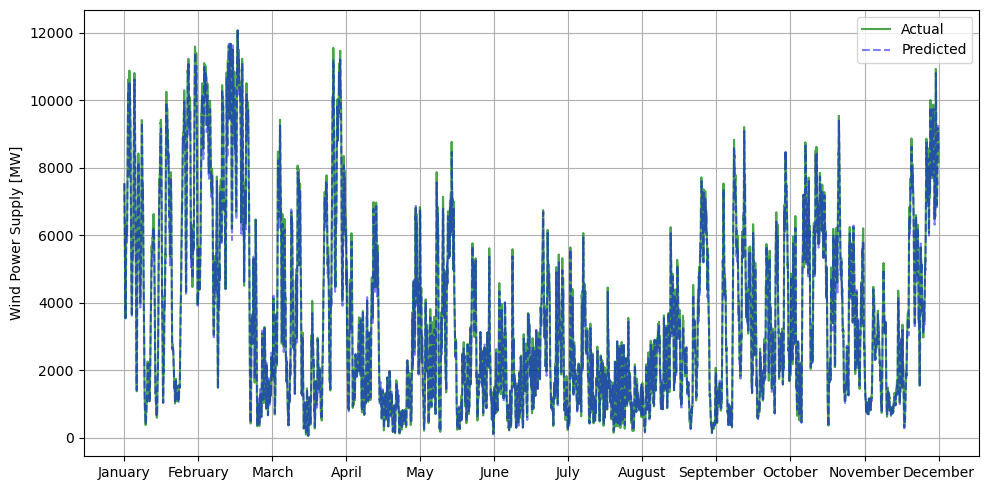

269.9281538331437


In [91]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
def myrooterror(y_true, y_pred):

    return np.sqrt(np.mean((y_true - y_pred)**2))

y_pred_hourly = model.predict(X_test_scaled)
y_test_hourly = y_test

indices = range(len(y_test))
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]


hourly_ticks = np.linspace(0, len(y_test_hourly)-1, len(months))


y_test_first_10 = y_test_hourly
y_pred_first_10 = y_pred_hourly

plt.figure(figsize=(10,5))
plt.plot(indices,y_test_first_10, linestyle='-', color='g',alpha=0.7,  label='Actual')
plt.plot(indices,y_pred_first_10,  linestyle='--', color='blue',alpha=0.5,  label='Predicted')
plt.xticks(ticks=hourly_ticks, labels=months)

plt.ylabel('Wind Power Supply [MW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('wind_power_supply.png', dpi=300)
plt.show()


rmse = np.sqrt(mean_squared_error(y_test_hourly,y_pred_hourly))
print(rmse)    

In [92]:
df_supply_list_24_train = []
df_supply_list_24_test = []
nna_count = 0
print(len(wind_supply_df))
for index, row in tqdm(wind_supply_df.iterrows(), total=len(wind_supply_df)):
    if float(row["year"]) in [2020.0, 2019.0,2021.0]:
        if index + 24 < len(wind_supply_df):
            df_supply_list_24_train.append(wind_supply_df['Wind Total [MW]'].iloc[index:index+24].values)
    elif float(row["year"]) in [2022.0]:
        if index + 24 < len(wind_supply_df):
            df_supply_list_24_test.append(wind_supply_df['Wind Total [MW]'].iloc[index:index+24].values)
    else:
        print("Row with unexpected year:", row["year"])


with open("24wind-y.txt", "w") as f:
    for item in df_supply_list_24_train:
        i =0
        f.write("%s\n" % item)

35064


100%|██████████| 35064/35064 [00:00<00:00, 36507.16it/s]


In [93]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
scaler = StandardScaler()

import numpy as np




X_train_scaled = np.array(df_wind_list_train[:-1])
print(X_train_scaled.shape)

y_train = np.array(df_supply_list_24_train[1:])
X_test_scaled= np.array(df_wind_list_test[:-25])

y_test = np.array(df_supply_list_24_test[1:])

model = CustomSequential([
    layers.Input(shape=(X_train_scaled.shape[1],)), 
    layers.Dense(512, activation='relu'), 
    layers.Dense(256, activation='relu'), 
    layers.Dense(128, activation='relu'),  
    layers.Dense(64, activation='relu'),   
    layers.Dense(32, activation='relu'),   
    layers.Dense(24)  
])

#sgd = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer="adam",
              loss='mean_squared_error',  
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]) 

history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=32)

test_loss, test_rmse = model.evaluate(X_test_scaled, y_test) 

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Root Mean Squared Error: {test_rmse:.4f}")




(26303, 165)
Epoch 1/40
822/822 [==============================] - 2s 1ms/step - loss: 3174487.2500 - rmse: 1781.7100
Epoch 2/40
822/822 [==============================] - 1s 1ms/step - loss: 2453821.0000 - rmse: 1566.4668
Epoch 3/40
822/822 [==============================] - 1s 1ms/step - loss: 2395333.0000 - rmse: 1547.6868
Epoch 4/40
822/822 [==============================] - 1s 1ms/step - loss: 2333679.0000 - rmse: 1527.6387
Epoch 5/40
822/822 [==============================] - 1s 1ms/step - loss: 2306248.7500 - rmse: 1518.6344
Epoch 6/40
822/822 [==============================] - 1s 1ms/step - loss: 2286281.7500 - rmse: 1512.0464
Epoch 7/40
822/822 [==============================] - 1s 1ms/step - loss: 2266370.0000 - rmse: 1505.4463
Epoch 8/40
822/822 [==============================] - 1s 1ms/step - loss: 2260929.0000 - rmse: 1503.6381
Epoch 9/40
822/822 [==============================] - 1s 1ms/step - loss: 2242875.2500 - rmse: 1497.6229
Epoch 10/40
822/822 [=====================

273/273 [==============================] - 0s 512us/step
tf.Tensor(0.0, shape=(), dtype=float64)


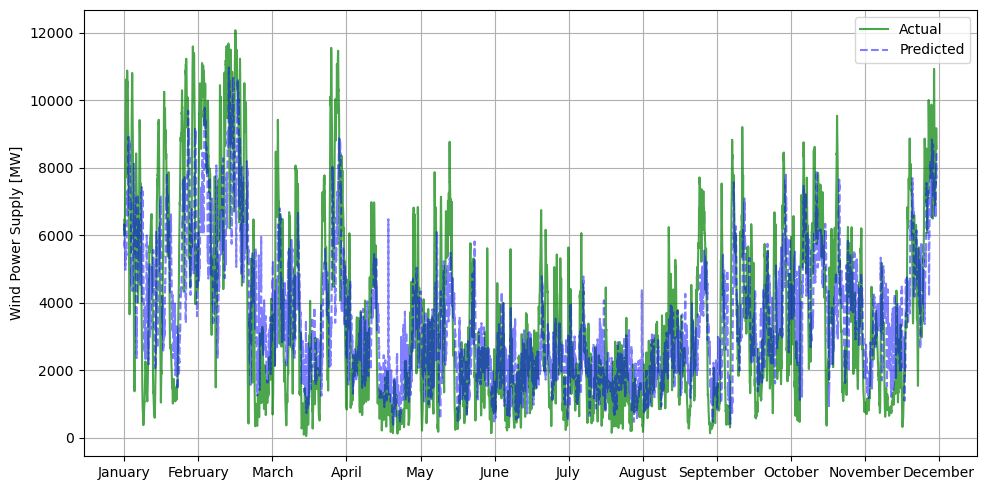

In [94]:
import matplotlib.pyplot as plt


y_pred = model.predict(X_test_scaled)
y_pred_24 = y_pred[:, 23]

indices = range(len(y_test))


y_test_first = y_test[:, 23]
y_pred_first = y_pred_24

print(myrmse(y_test_first,y_test_first))

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]


hourly_ticks = np.linspace(0, len(y_test_hourly)-1, len(months))

# Plotting
plt.figure(figsize=(10,5))
plt.plot(indices,y_test_first, linestyle='-', color='g',alpha=0.7,  label='Actual')
plt.plot(indices,y_pred_first,  linestyle='--', color='blue',alpha=0.5,  label='Predicted')

plt.ylabel('Wind Power Supply [MW]')

plt.xticks(ticks=hourly_ticks, labels=months)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('wind_power_supply_daily.png', dpi=300)
plt.show()
